# Pan-sharpening Landsat using the Brovey Transform <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3)

## Background

Panchromatic sharpening ("pan-sharpening") is an image processing technique used to increase the spatial resolution of coarser resolution multispectral satellite image using a higher resolution panchromatic satellite band.

Compared to multispectral satellite bands that cover multiple narrow portions of the electromagnetic spectrum, a panchromatic satellite band covers a wide range of spectra that typically overlaps with multiple other bands (e.g. covering both visible and near-infrared radiation).
This wider spectral range can allow panchromatic bands to be collected at a higher spatial resolution due to a higher incoming signal-to-noise ratio.

By fusing multiple medium resolution multispectral bands with high resolution panchromatic data, pan-sharpening can be used to produce a new high resolution multispectral dataset that balances both spectral resolution and spatial resolution of these two input data sources.

## Description
In this example we will load Landsat 8 data and use the Brovey Transformation along with the panchromatic band to generate a higher resolution RGB image.

1. First we will define our area of interest
2. Then we will set up the Brovey Transform
3. Load data at upsampled 15 x 15 m resolution and load data at native 30 x 30 m resolution for reference
4. Plot and compare the outputs

***

## Getting started

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_datahandling import pan_sharpen_brovey

### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [2]:
dc = datacube.Datacube(app='Pan_sharpening_Brovey')


### Analysis parameters

* `product`: The name of the product to pan-sharpen. This method works on DEA Landsat Collection 3 ARD Landsat 7 and Landsat 8 data - `ga_ls8c_ard_3` and `ga_ls7e_ard_3` are valid choices.
* `resolution`: Most Landsat bands collect data at a 30 x 30 m resolution, with the exception of the panchromatic band which is at 15 x 15 m.
Unless you are using this example with a different sensor, leave this at `(-15, 15)`.
* `align`: Alignment of the centre of the pixel. 
Leave this at `(7.5,7.5)` unless you know the data you are using requires a different pixel alignment
* `resampling`: When we use the DataCube to upsample the red, green and blue bands this is the resampling method to use. 
It is suggested to use `'bilinear'` however if you wish to experiment with different resampling methods you can use any of the [available methods here](https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py#L28).
* `lon, lat, time`: Parameters to define our area of interest - feel free to adjust these.
* `measurements`: Landsat 7 and Landsat 8 have slightly different sensor configurations. 
For Landsat 8, Brovey Transform pan-sharpening should only be used with red, green and blue satellite bands. 
For Landsat 7, pan-sharpening can be used with red, green, blue and near infrared (`nbart_nir` or `nbar_nir`). 
For a visual explanation [see here]( https://landsat.gsfc.nasa.gov/wp-content/uploads/2013/01/ETM+vOLI-TIRS-web_Feb20131.jpg). 
An alternative selection of measurements could be `['nbart_red','nbart_green','nbart_blue','nbart_panchromatic']` but ensure that all your measurements are either terrain corrected (`nbart_`) or non-terrain corrected (`nbar_`).


In [3]:
# Currently this is only available for Landsat 7 and Landsat 8 
# GA Landsat Collection 3 data
product = 'ga_ls8c_ard_3'

# We want to retrieve all data at the panchromatic band resolution
resolution = (-15, 15)
align = (7.5, 7.5)
resampling = 'bilinear'

# Parliament House
lon = (149.11, 149.14)
lat = (-35.31, -35.29)

# An arbitrary time
time = '2015-01-02'

# Let's retrieve the red, green, blue and pan bands - this method of pan 
# sharpening should only be used with the red, green and blue bands
measurements = ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_panchromatic']

### Determine native resolution (optional)
This section ensures your data is loaded in its 'native projection': the projection the data is stored in on file.
This will ensure maximum fidelity of your data by preventing data from being needlessly re-projected when loaded.

If this is not required, or you intend on re-projecting to a different CRS (e.g. `EPSG:3577`), then simply nominate your target CRS as `output_crs`.

In [4]:
# For the purposes of using our target dataset's native projection, 
# let's find determine it's native crs before loading - while this 
# yields best results, it is optional
md = dc.find_datasets(product=product, lon=lon, lat=lat, time=time,
                      limit=1)[0].metadata_doc
dataset_id = md['id']  # Ensure we only return the exact dataset that we want (optional)
output_crs = md['crs']  # Using native projection (optional)


## Loading data
In this example we combine the Brovey Transform, Landsat 8's panchromatic band and multispectral data resampled using bilinear interpolation to pan-sharpen the red, green and blue Landsat bands from 30 x 30 m resolution to 15 x 15 m. 

In the cells below, we load red, green, blue and panchromatic band data at 15 m resolution, resampling the three visual bands using the `resampling` method specified above. 
For comparison, we also load the same three visual bands at their native 30 m resolution to serve as a reference dataset.

In [5]:
# Load red, green, blue and panchromatic band data for our area of 
# interest at 15 m resolution
nbar_rgbp_15m = dc.load(product=product,
                        id=dataset_id,
                        resolution=resolution,
                        align=align,
                        output_crs=output_crs,
                        resampling=resampling,
                        lon=lon,
                        lat=lat,
                        measurements=measurements)


In [6]:
# For reference, load the same image at 30 m resolution
nbar_rgb_30m = dc.load(product=product,
                       id=dataset_id,
                       resolution=(-30, 30),
                       align=(15, 15),
                       output_crs=output_crs,
                       lon=lon,
                       lat=lat,
                       measurements=['nbart_red', 'nbart_green', 'nbart_blue'])


### Visualise the panchromatic band
To visualise how the spatial resolution of Landsat's panchromatic band compares to the spatial resolution of the red, green and blue bands, we can plot both options side-by-side. 
In the example below, we plot the 30 m Landsat 8 green band on the left, and the 15 m panchromatic band on the right. 
It should be clear how much additional spatial detail is visible in the panchromatic band:

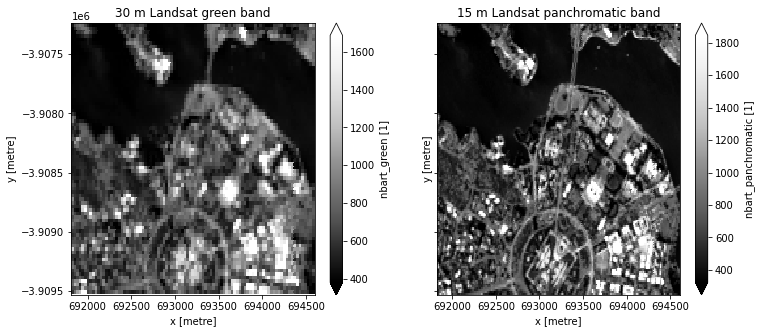

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
nbar_rgb_30m.nbart_green.plot(ax=axes[0], cmap='Greys_r', robust=True)
nbar_rgbp_15m.nbart_panchromatic.plot(ax=axes[1], cmap='Greys_r', robust=True)
axes[0].set_title('30 m Landsat green band')
axes[1].set_title('15 m Landsat panchromatic band');


## Pan-sharpening Landsat 8 using the Brovey Transform
The Brovey Transform is a simple algorithm developed to optimise visual contrast at both ends of the satellite data's histogram. 
The approach multiplies each medium resolution band by the ratio of the higher resolution panchromatic band divided by the sum of all three multispectral bands. Brovey is primarily suitable for visual analysis and is not "great" at transforming Landsat's Blue band.

To perform Brovey pan-sharpening, we pass `xarray.DataArrays` for each of our satellite bands to the `pan_sharpen_brovey` function from the `dea_datahandling` script.
For more detail on the implementation, [inspect the function here](../Scripts/dea_datahandling.py).

> **Note:** If you choose to access different satellite bands (measurements), they will need to be altered here

In [ ]:
# Perform Brovey pan-sharpening and return three numpy.arrays
red_sharpen, green_sharpen, blue_sharpen = pan_sharpen_brovey(
    band_1=nbar_rgbp_15m.nbart_red,
    band_2=nbar_rgbp_15m.nbart_green,
    band_3=nbar_rgbp_15m.nbart_blue,
    pan_band=nbar_rgbp_15m.nbart_panchromatic)


### Reconstruct xarray.Dataset
Because the `pan_sharpen_brovey` function returns data as three `numpy.arrays`, it can be useful to re-combine our output data into an `xarray.Dataset` that can be used for future analyses. 
Depending on the application at hand, this step may be optional.

In [ ]:
# Copy the coordinates and dimensions from the original dataset
time = nbar_rgbp_15m.time
y = nbar_rgbp_15m.y
x = nbar_rgbp_15m.x
coords = [time, y, x]
dims = ['time', 'y', 'x']

# Create new data arrays
red_data_array = xr.DataArray(red_sharpen, coords=coords, dims=dims)
green_data_array = xr.DataArray(green_sharpen, coords=coords, dims=dims)
blue_data_array = xr.DataArray(blue_sharpen, coords=coords, dims=dims)

sharp_rgb = xr.Dataset({'red': red_data_array, 
                        'green': green_data_array, 
                        'blue': blue_data_array}, 
                       coords={'time': time, 'y': y,'x': x})

## Visualise output compared to reference data

### Plot red, green and blue bands at native 30 x 30 m resolution
To evaluate our pan-sharpened image, we can compare it with our previously loaded reference data.
First, we plot our reference data at its original 30 m resolution:

In [ ]:
rgb(ds=nbar_rgb_30m, bands=['nbart_red', 'nbart_green', 'nbart_blue'], size=8)


### Plot red, green and blue bands at interporlated 15 x 15 m resolution
We can also plot the data after it was re-sampled to 15 x 15 m resolution using the `resampling` method we specified above.
Although this image has a higher resolution, the resampling step causes the result to appear blurred and difficult to interpret:

In [ ]:
rgb(ds=nbar_rgbp_15m, bands=['nbart_red', 'nbart_green', 'nbart_blue'], size=8)


### Plot pan-sharpened red, green and blue bands at 15 x 15 m resolution
Finally, we can plot our pan-sharped image. 
Compared to the two examples above, this image appears sharp and detailed, while still retaining the multispectral data (i.e. RGB colours) that was not originally included in the panchromatic band:

In [ ]:
rgb(ds=sharp_rgb, bands=['red', 'green', 'blue'], size=8, index=0)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)